<a href="https://colab.research.google.com/github/lieson-bit/Data-mining-based-on-machine-learning-methods/blob/main/Regression_analysis_lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Регрессионная задача по болезни Паркинсона  

Мы стремимся **предсказать тяжесть болезни Паркинсона** на основе **голосовых характеристик и демографических данных** пациента.  
- **Целевая переменная:** `total_UPDRS` (клиническая оценка степени тяжести заболевания).  
- **Признаки:** акустические показатели речи (например, Jitter, Shimmer, NHR, RPDE, PPE) + возраст + пол.  
- **Почему регрессия?** `total_UPDRS` — это непрерывная величина, поэтому задача относится к регрессии, а не классификации.  

✅ Цель: построить модель, которая по этим признакам сможет **оценивать тяжесть Паркинсона** и помогать в раннем мониторинге.  


In [35]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from scipy.stats import skew, kurtosis
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Bidirectional, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, TransformerMixin
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# === Set random seeds for reproducibility ===
np.random.seed(42)
tf.random.set_seed(42)

### 🗃️ Загрузка набора данных

Загрузите CSV-файл в DataFrame библиотеки Pandas для удобной обработки и анализа.


In [36]:
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/V5.csv"
df = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 💡 1. Процесс разведочного анализа данных (EDA)


### 📝 i. Основная информация о наборе данных

Суммируем ключевые характеристики набора данных: размер, количество пациентов, признаки, целевая переменная и пропущенные значения.


In [37]:
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

print("\nFirst 5 rows:")
display(df.head())
size_mb = os.path.getsize(data_path) / (1024 * 1024)

print("=== Main Dataset Information ===")
print(f"1️⃣ Dataset size: {size_mb:.2f} MB")
print(f"2️⃣ Number of records: {len(df)}")
print(f"3️⃣ Number of features: {len(df.columns)}")
print(f"4️⃣ Target column: 'total_UPDRS' (dtype: {df['total_UPDRS'].dtype})")
print(f"5️⃣ Categorical feature: 'sex' (binary 0/1)")
print(f"6️⃣ Unique subjects: {df['subject#'].nunique()}")
print(f"7️⃣ Test time span: {df['test_time'].min()} → {df['test_time'].max()}")

print("\n=== Missing Values (per column) ===")
print(df.isnull().sum())

print("\n=== Missing Values (per row) ===")
print(df.isnull().sum(axis=1).value_counts().sort_index())

print("=== Feature Types ===")
print(df.dtypes)

# === Remove motor_UPDRS ===
if 'motor_UPDRS' in df.columns:
    df = df.drop('motor_UPDRS', axis=1)
    print("\n✅ 'motor_UPDRS' column removed.")

Shape: (5875, 24)
Columns: ['Unnamed: 0', 'index', 'subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

First 5 rows:


,Unnamed: 0,index,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,0,0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,2,2,1,72,0,19.6810,28.695,35.389,0.00481,NaN,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,3,3,1,72,0,25.6470,28.905,35.810,0.00528,NaN,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,4,4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


=== Main Dataset Information ===
1️⃣ Dataset size: 0.90 MB
2️⃣ Number of records: 5875
3️⃣ Number of features: 24
4️⃣ Target column: 'total_UPDRS' (dtype: float64)
5️⃣ Categorical feature: 'sex' (binary 0/1)
6️⃣ Unique subjects: 42
7️⃣ Test time span: -4.2625 → 215.49

=== Missing Values (per column) ===
Unnamed: 0          0
index               0
subject#            0
age                 0
sex                 0
test_time           0
motor_UPDRS         0
total_UPDRS         0
Jitter(%)           0
Jitter(Abs)      2931
Jitter:RAP          0
Jitter:PPQ5         0
Jitter:DDP          0
Shimmer             0
Shimmer(dB)         0
Shimmer:APQ3        0
Shimmer:APQ5        0
Shimmer:APQ11       0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
PPE                 0
dtype: int64

=== Missing Values (per row) ===
0    2944
1    2931
Name: count, dtype: int64
=== Feature Types ===
Unnamed: 0         int64
index              int64
s

## ii. 📈 Описательная статистика

Получите статистический обзор числовых признаков в наборе данных: среднее значение, стандартное отклонение, минимум, максимум и квартильные значения.


=== Dataset Descriptive Statistics ===


,Unnamed: 0,index,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,2944.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,2937.000000,2937.000000,21.494128,64.804936,0.317787,92.863722,29.018942,0.006154,0.000044,0.002987,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,1696.110747,1696.110747,12.372279,8.821524,0.465656,53.445602,10.700283,0.005624,0.000036,0.003124,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,0.000000,0.000000,1.000000,36.000000,0.000000,-4.262500,7.000000,0.000830,0.000002,0.000330,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,1468.500000,1468.500000,10.000000,58.000000,0.000000,46.847500,21.371000,0.003580,0.000023,0.001580,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,2937.000000,2937.000000,22.000000,65.000000,0.000000,91.523000,27.576000,0.004900,0.000035,0.002250,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,4405.500000,4405.500000,33.000000,72.000000,1.000000,138.445000,36.399000,0.006800,0.000053,0.003290,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,5874.000000,5874.000000,42.000000,85.000000,1.000000,215.490000,54.992000,0.099990,0.000396,0.057540,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730



=== Subject Measurement Counts ===
Average per subject: 139.88
Min per subject: 101, Max per subject: 168


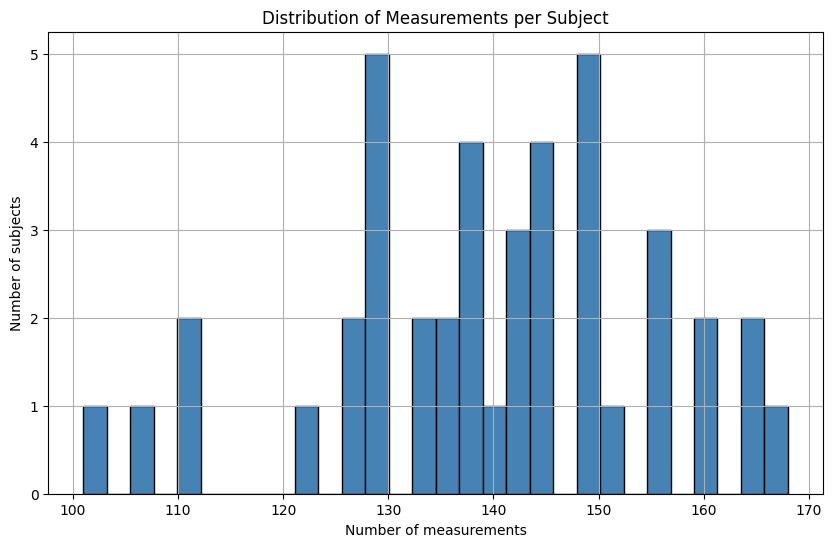

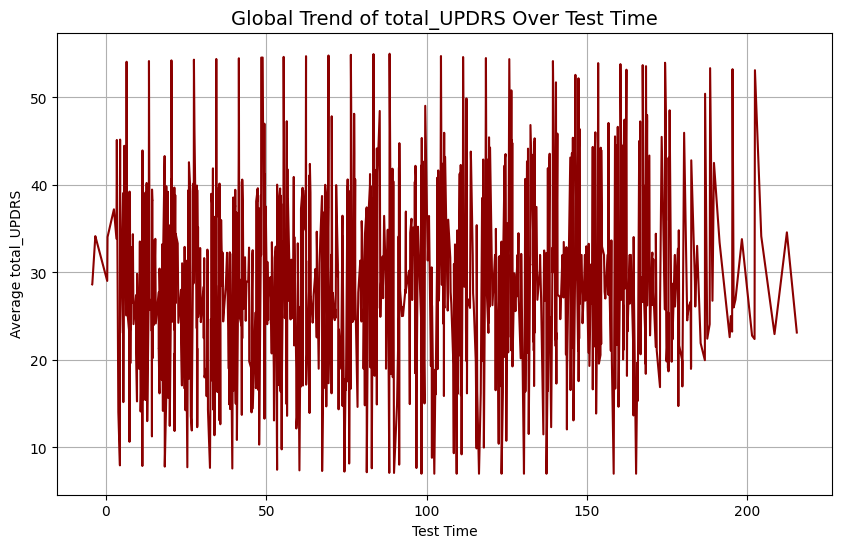

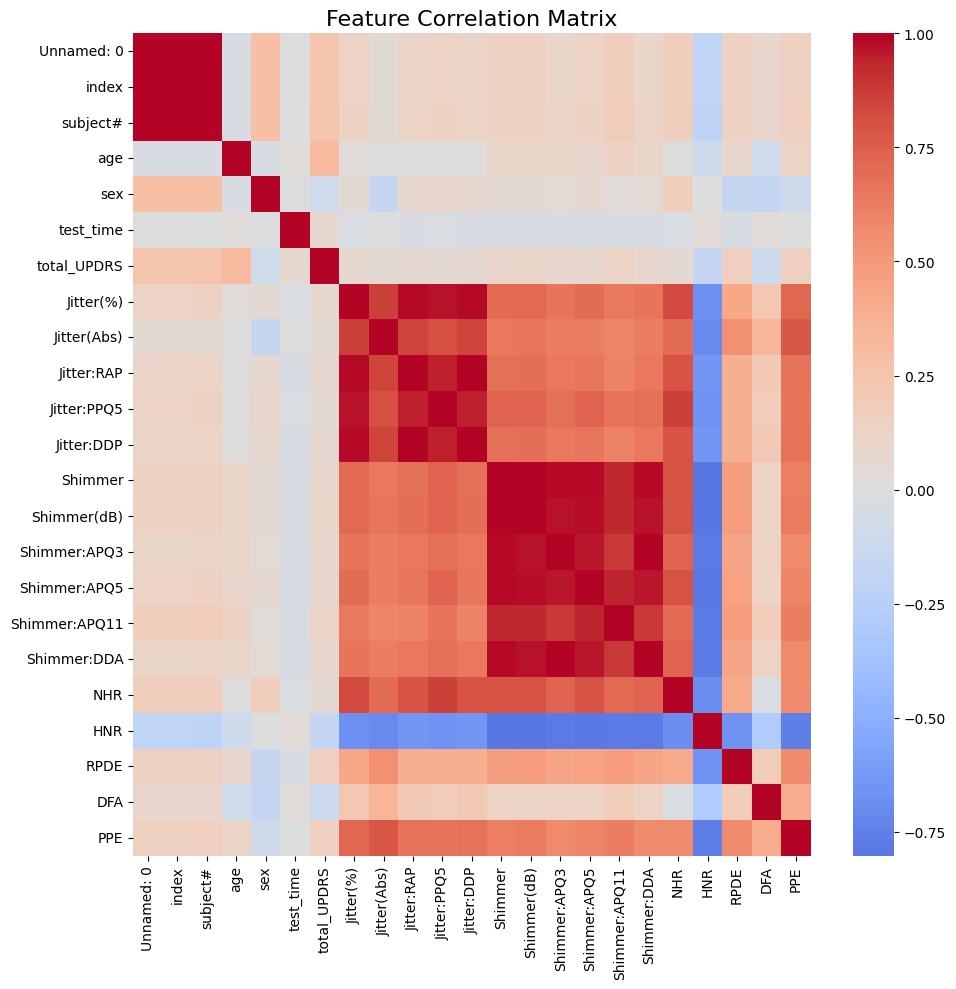


=== Correlation of Features with total_UPDRS ===
total_UPDRS      1.000000
age              0.310290
subject#         0.253643
index            0.251196
Unnamed: 0       0.251196
RPDE             0.156897
PPE              0.156195
Shimmer:APQ11    0.120838
Shimmer(dB)      0.098790
Shimmer          0.092141
Shimmer:APQ5     0.083467
Shimmer:DDA      0.079363
Shimmer:APQ3     0.079363
test_time        0.075263
Jitter(%)        0.074247
Jitter:DDP       0.064027
Jitter:RAP       0.064015
Jitter:PPQ5      0.063352
NHR              0.060952
Jitter(Abs)      0.054074
sex             -0.096559
DFA             -0.113475
HNR             -0.162117
Name: total_UPDRS, dtype: float64

=== Feature Pair Correlation Table ===


,Feature 1,Feature 2,Correlation,Comment
0,Unnamed: 0,index,1.000000,⚠️ Possible redundancy (|corr| > 0.9)
219,Shimmer:APQ3,Shimmer:DDA,1.000000,⚠️ Possible redundancy (|corr| > 0.9)
163,Jitter:RAP,Jitter:DDP,1.000000,⚠️ Possible redundancy (|corr| > 0.9)
1,Unnamed: 0,subject#,0.999544,⚠️ Possible redundancy (|corr| > 0.9)
22,index,subject#,0.999544,⚠️ Possible redundancy (|corr| > 0.9)
198,Shimmer,Shimmer(dB),0.992334,⚠️ Possible redundancy (|corr| > 0.9)
200,Shimmer,Shimmer:APQ5,0.984904,⚠️ Possible redundancy (|corr| > 0.9)
136,Jitter(%),Jitter:DDP,0.984184,⚠️ Possible redundancy (|corr| > 0.9)
134,Jitter(%),Jitter:RAP,0.984181,⚠️ Possible redundancy (|corr| > 0.9)
199,Shimmer,Shimmer:APQ3,0.979828,⚠️ Possible redundancy (|corr| > 0.9)



=== Skewness and Kurtosis (numeric features) ===


,Skewness,Kurtosis
Unnamed: 0,0.000000,-1.200000
index,0.000000,-1.200000
subject#,0.002996,-1.249432
age,-0.379037,0.668864
sex,0.782674,-1.387422
test_time,0.077700,-1.147422
total_UPDRS,0.270984,-0.356422
Jitter(%),6.450198,67.438108
Jitter(Abs),3.239836,17.579714
Jitter:RAP,6.943665,78.466738


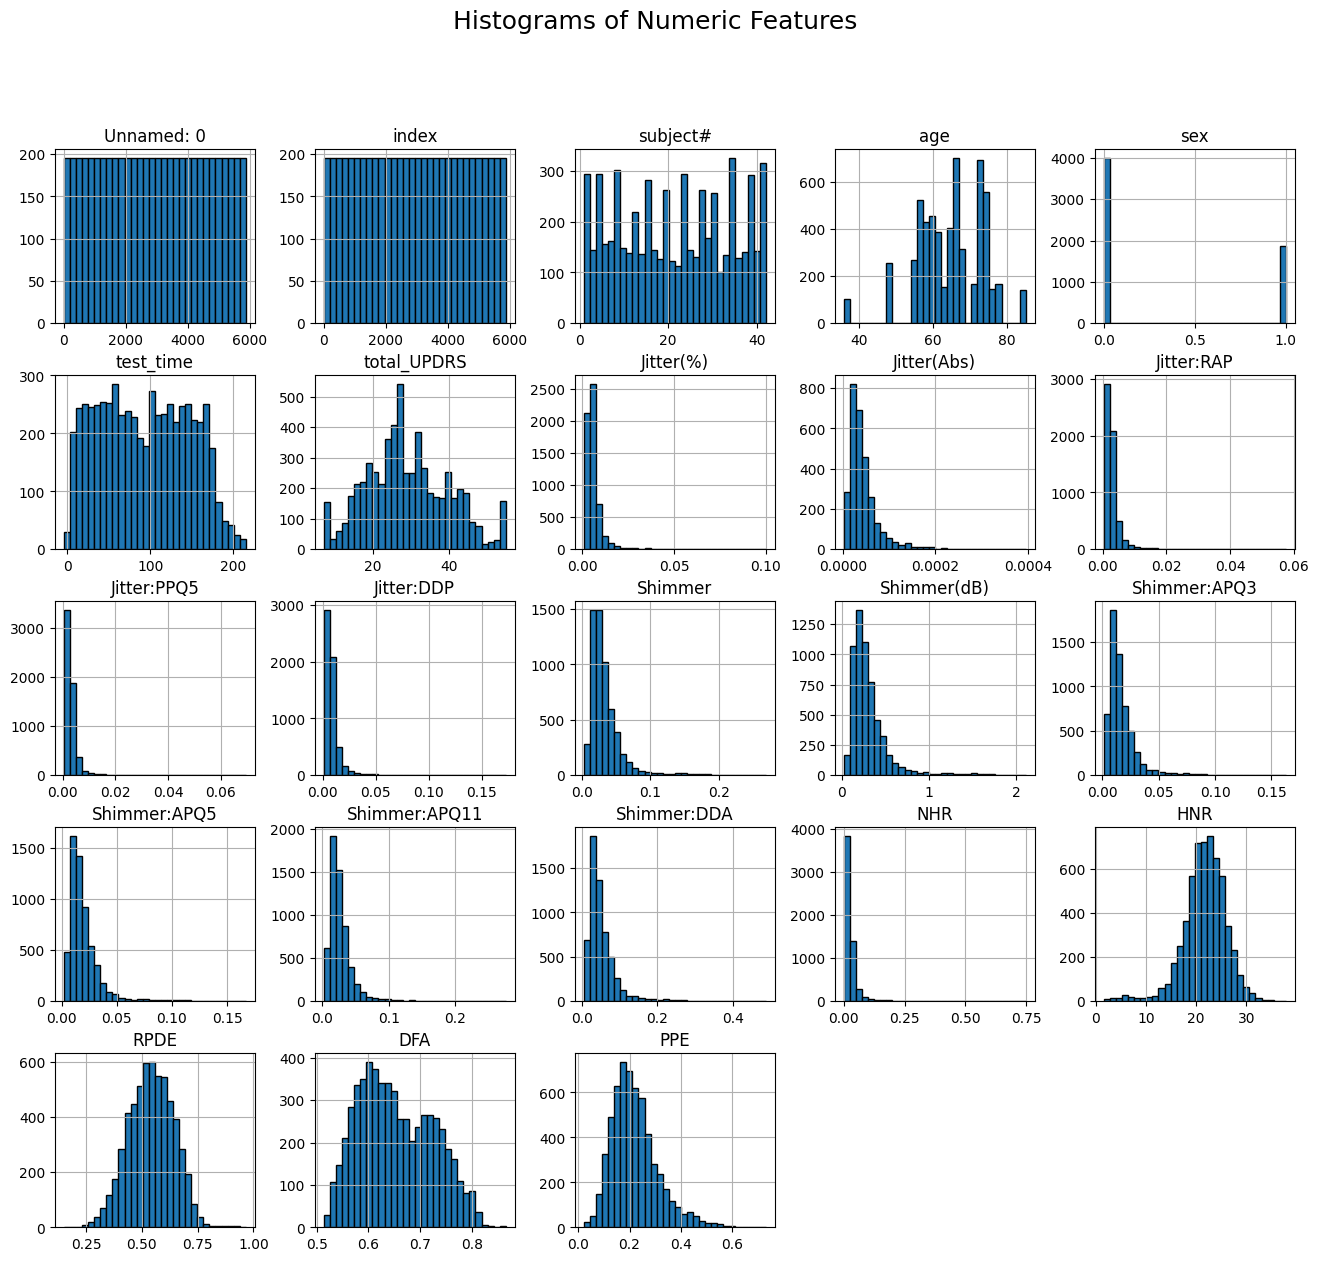

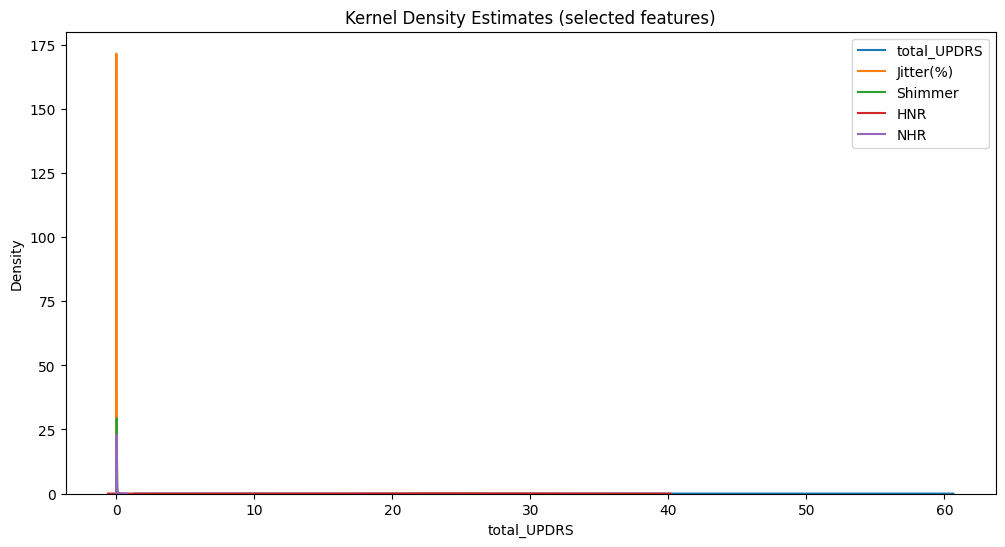


=== Outlier Detection (IQR method) ===


,Num_Outliers
NHR,436
Jitter:PPQ5,425
Jitter:RAP,414
Jitter:DDP,413
Jitter(%),398
Shimmer,333
Shimmer:APQ3,332
Shimmer(dB),332
Shimmer:DDA,331
Shimmer:APQ5,314


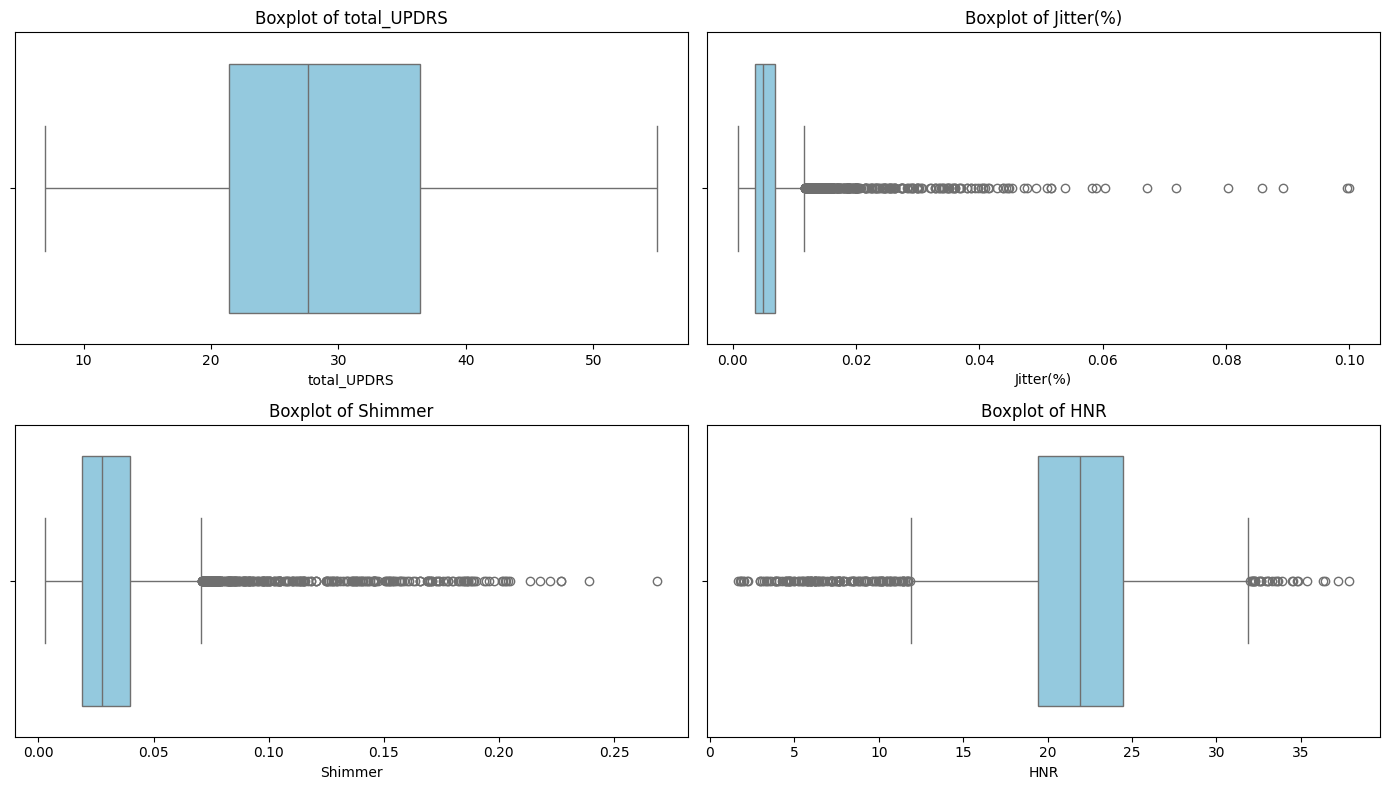

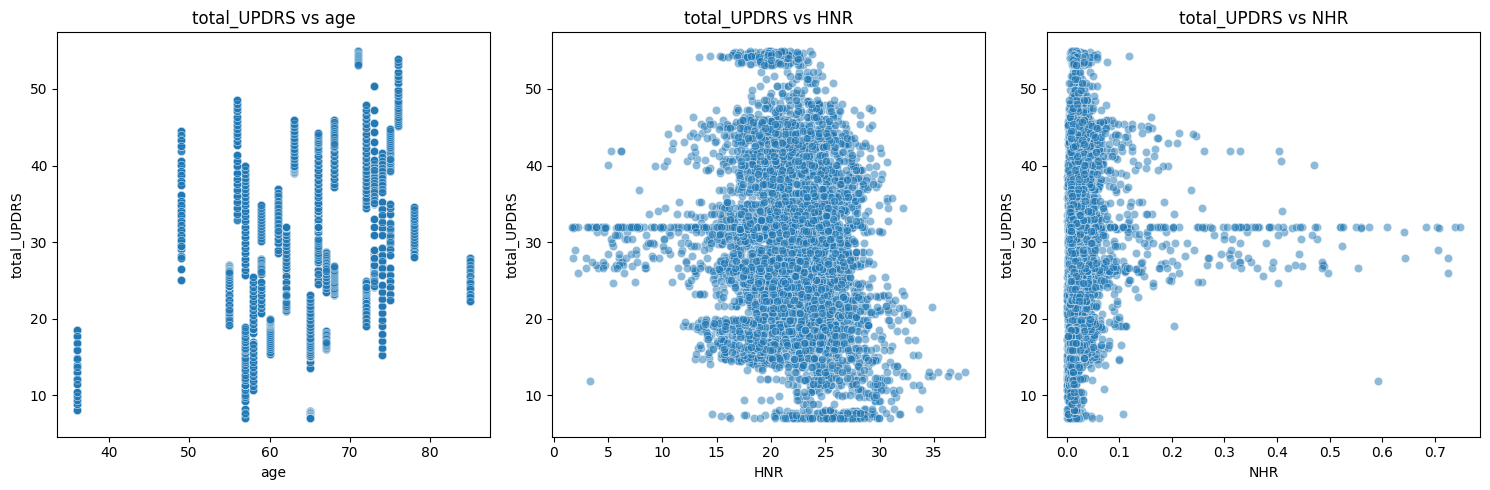

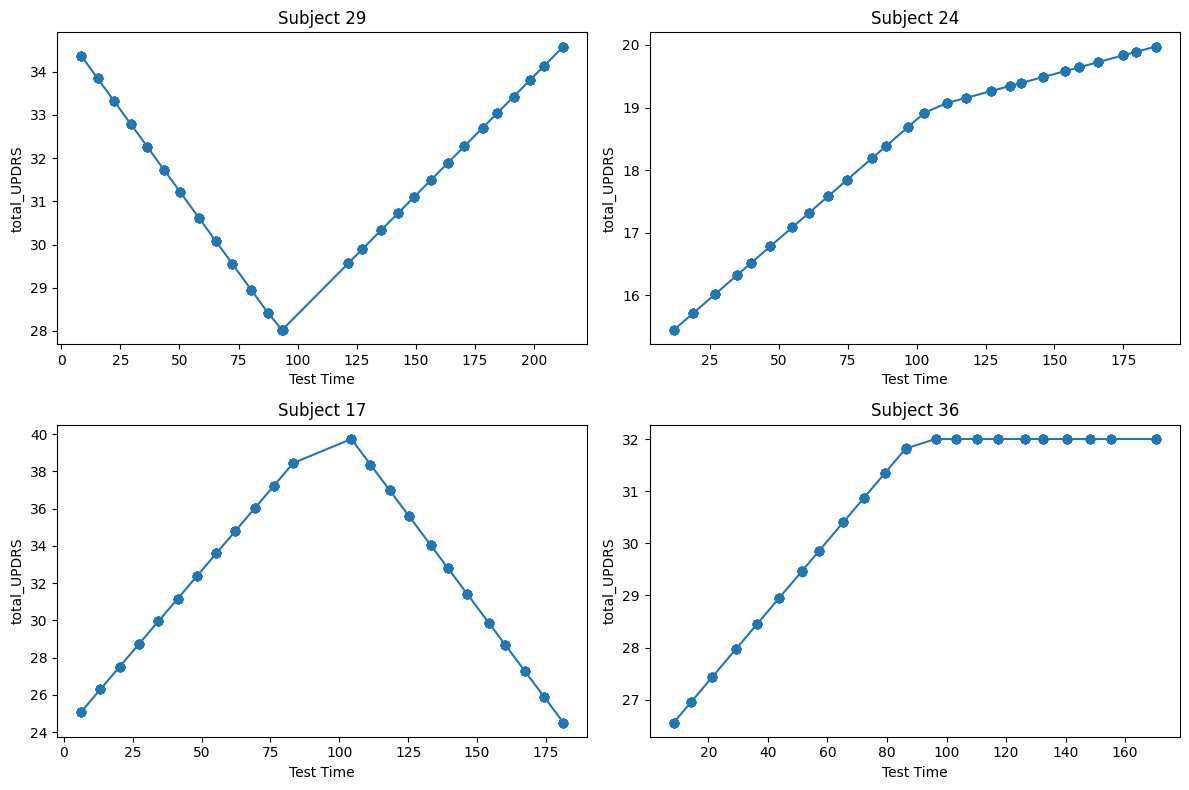

In [42]:


print("=== Dataset Descriptive Statistics ===")
display(df.describe(include="all"))

# === Subject-level statistics ===
subject_counts = df['subject#'].value_counts()
print("\n=== Subject Measurement Counts ===")
print(f"Average per subject: {subject_counts.mean():.2f}")
print(f"Min per subject: {subject_counts.min()}, Max per subject: {subject_counts.max()}")

plt.figure(figsize=(10,6))
subject_counts.hist(bins=30, color="steelblue", edgecolor="black")
plt.title("Distribution of Measurements per Subject")
plt.xlabel("Number of measurements")
plt.ylabel("Number of subjects")
plt.show()
print("")

# === Global trend of total_UPDRS over test_time ===
plt.figure(figsize=(10,6))
df_grouped = df.groupby("test_time")["total_UPDRS"].mean()
plt.plot(df_grouped.index, df_grouped.values, color="darkred")
plt.title("Global Trend of total_UPDRS Over Test Time", fontsize=14)
plt.xlabel("Test Time")
plt.ylabel("Average total_UPDRS")
plt.grid(True)
plt.show()

print("")

# === Correlation analysis ===
corr_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

target_corr = corr_matrix['total_UPDRS'].sort_values(ascending=False)
print("\n=== Correlation of Features with total_UPDRS ===")
print(target_corr)

# === Highly Correlated Feature Pairs (with comments) ===
high_corr_records = []

for i, col1 in enumerate(corr_matrix.columns):
    for j, col2 in enumerate(corr_matrix.columns):
        if i < j:  # avoid duplicates & self-correlation
            corr_val = corr_matrix.loc[col1, col2]
            comment = (
                "⚠️ Possible redundancy (|corr| > 0.9)"
                if abs(corr_val) > 0.9
                else "No redundancy concern"
            )
            high_corr_records.append((col1, col2, corr_val, comment))

# Convert to DataFrame for nice display
high_corr_df = pd.DataFrame(
    high_corr_records,
    columns=["Feature 1", "Feature 2", "Correlation", "Comment"]
).sort_values(by="Correlation", key=lambda x: abs(x), ascending=False)

print("\n=== Feature Pair Correlation Table ===")
display(high_corr_df.head(20))  # show top 20 strongest correlations


# === Distribution & Skewness Analysis ===
numeric_features = df.select_dtypes(include=[np.number]).columns
print("\n=== Skewness and Kurtosis (numeric features) ===")
skew_kurt = pd.DataFrame({
    "Skewness": df[numeric_features].apply(lambda x: skew(x.dropna())),
    "Kurtosis": df[numeric_features].apply(lambda x: kurtosis(x.dropna()))
})
display(skew_kurt)

df[numeric_features].hist(figsize=(16, 14), bins=30, edgecolor="black")
plt.suptitle("Histograms of Numeric Features", fontsize=18)
plt.show()

plt.figure(figsize=(12, 6))
for col in ['total_UPDRS', 'Jitter(%)', 'Shimmer', 'HNR', 'NHR']:
    sns.kdeplot(df[col].dropna(), label=col)
plt.title("Kernel Density Estimates (selected features)")
plt.legend()
plt.show()

# === Outlier Detection with IQR ===
print("\n=== Outlier Detection (IQR method) ===")
outlier_summary = {}
for col in numeric_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = n_outliers
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient="index", columns=["Num_Outliers"])
display(outlier_df.sort_values("Num_Outliers", ascending=False).head(10))

plt.figure(figsize=(14, 8))
for i, col in enumerate(['total_UPDRS', 'Jitter(%)', 'Shimmer', 'HNR']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# === Scatterplots: target vs selected features ===
top_features = ['age', 'HNR', 'NHR']
plt.figure(figsize=(15, 5))
for i, feat in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df[feat], y=df['total_UPDRS'], alpha=0.5)
    plt.title(f'total_UPDRS vs {feat}')
plt.tight_layout()
plt.show()

# === Temporal trends for a few subjects ===
subject_sample = np.random.choice(df['subject#'].unique(), 4, replace=False)
plt.figure(figsize=(12, 8))
for i, subject in enumerate(subject_sample):
    subject_data = df[df['subject#'] == subject].sort_values('test_time')
    plt.subplot(2, 2, i+1)
    plt.plot(subject_data['test_time'], subject_data['total_UPDRS'], marker='o', linestyle='-')
    plt.title(f'Subject {subject}', fontsize=12)
    plt.xlabel('Test Time')
    plt.ylabel('total_UPDRS')
plt.tight_layout()
plt.show()



# Интерпретация графиков и статистики

## 1. Распределение количества измерений на одного пациента
**Что показывает:** Гистограмма количества измерений для каждого пациента.  
**Интерпретация:** У большинства пациентов от ~130 до 160 измерений, с пиками около 140–150. Очень мало пациентов имеют меньше 120 или больше 160 измерений.  
**Почему это важно:** Набор данных сбалансирован по пациентам, ни один пациент не доминирует.

---

## 2. Глобальный тренд total_UPDRS во времени (test_time)
**Что показывает:** Линейный график среднего значения UPDRS по всем пациентам в зависимости от времени теста.  
**Интерпретация:** Линия колеблется с пиками и впадинами — выраженность симптомов (UPDRS) изменяется во времени, а не следует плавному тренду.  
**Почему это важно:** Это указывает на вариабельность прогрессирования болезни или шум измерений. Модели должны учитывать временные колебания.

---

## 3. Матрица корреляций признаков
**Что показывает:** Тепловая карта корреляций между всеми признаками.  
**Интерпретация:**  
- Возраст имеет умеренную положительную корреляцию с total_UPDRS.  
- Jitter/Shimmer/Test_time/PPE/RPDE имеют слабую положительную корреляцию .  
- HNR, DFA и пол показывают отрицательную корреляцию.  
- Признаки jitter и shimmer сильно коррелированы между собой (избыточность).  
**Почему это важно:** Помогает выявить предикторы UPDRS и определить избыточные признаки.

---

## 4. Гистограммы числовых признаков
**Что показывает:** Распределение каждого числового признака.  
**Интерпретация:**  
- Возраст: большинство пациентов 50–80 лет.  
- Пол: бинарное распределение (мужчины/женщины).  
- total_UPDRS: одномодальное, слегка скошено вправо (у большинства пациентов низкие значения).  
- Jitter/Shimmer: сильно скошены вправо (много нулевых значений и редкие большие выбросы).  
**Почему это важно:** Скошенные признаки могут требовать трансформации (например, логарифмирования).

---

## 5. Гистограммы голосовых признаков (Jitter/Shimmer/NHR/HNR)
**Что показывает:** Распределения акустических признаков.  
**Интерпретация:**  
- Большинство значений jitter/shimmer очень малы, но есть длинные правые хвосты (выбросы).  
- NHR также скошен вправо.  
- HNR более симметричен.  
**Почему это важно:** Подтверждает, что голосовые признаки шумные и скошенные, что объясняет высокие значения асимметрии и эксцесса.

---

## 6. Оценки плотности распределений (KDE) для выбранных признаков
**Что показывает:** Сглаженные кривые плотности для UPDRS и некоторых акустических признаков.  
**Интерпретация:**  
- total_UPDRS имеет широкое распределение.  
- Jitter(%) имеет резкий пик около нуля.  
- Shimmer и NHR также сосредоточены вблизи низких значений.  
- HNR распределён более равномерно.  
**Почему это важно:** KDE показывает различия в масштабе и форме распределений, полезно для предобработки.

---

## 7. Боксплоты total_UPDRS и Jitter(%)
**Что показывает:** Распределение, разброс и выбросы.  
**Интерпретация:**  
- total_UPDRS: относительно симметричен, без экстремальных выбросов.  
- Jitter(%): сильно скошен, много выбросов с высокими значениями.  
**Почему это важно:** Подтверждает, что jitter требует устойчивого масштабирования или обработки выбросов.

---

## 8. Боксплоты Shimmer и HNR
**Что показывает:** Разброс и выбросы для shimmer и HNR.  
**Интерпретация:**  
- Shimmer: скошен вправо, много выбросов.  
- HNR: более симметричен, но также содержит выбросы.  
**Почему это важно:** Shimmer шумный, HNR чище, но отрицательно коррелирует с UPDRS.

---

## 9. Диаграммы рассеяния: total_UPDRS vs Age, HNR, NHR
**Что показывает:** Связь между UPDRS и выбранными признаками.  
**Интерпретация:**  
- Возраст: восходящий тренд → пожилые пациенты имеют более высокие UPDRS.  
- HNR: нисходящий тренд → лучшее качество голоса (HNR) связано с меньшими UPDRS.  
- NHR: восходящий тренд → больше шума в голосе связано с более высокими UPDRS.  
**Почему это важно:** Эти связи клинически интуитивны и подтверждают матрицу корреляций.

---

## 10. Временные тренды для отдельных пациентов
**Что показывает:** Изменение UPDRS во времени для 4 случайных пациентов.  
**Интерпретация:** У каждого пациента наблюдаются колебания, а не плавное прогрессирование. У некоторых состояние улучшается, у других ухудшается, у третьих колеблется.  
**Почему это важно:** Прогрессирование болезни Паркинсона нелинейно; модели должны учитывать индивидуальную вариабельность.

---

## 📊 Консольная статистика (Асимметрия, Эксцесс, Выбросы)

- **Асимметрия (Skewness):**  
  - Близко к 0 → симметричное распределение (возраст, UPDRS).  
  - Высокая положительная (>3) → длинный правый хвост (jitter, shimmer, NHR).  
  - Отрицательная → левый хвост (HNR).  

- **Эксцесс (Kurtosis):**  
  - Высокий (>10) → тяжёлые хвосты, экстремальные выбросы (jitter/shimmer).  
  - Близко к 0 → нормальное распределение (возраст, UPDRS).  

- **Выбросы (IQR):**  
  - Наибольшее количество выбросов у NHR, jitter и shimmer.  
  - Эти признаки шумные и требуют предобработки.

---

## ✅ Итог

- **Возраст** — самый сильный неакустический предиктор UPDRS.  
- **Голосовые признаки (jitter, shimmer, NHR/HNR)** — шумные, скошенные и с большим количеством выбросов, но содержат полезный сигнал.  
- **Корреляции** подтверждают избыточность внутри семейств jitter/shimmer.  
- **Временные графики** показывают вариабельность между пациентами и во времени.  
- **Необходима предобработка:** масштабирование, обработка выбросов, отбор признаков или понижение размерности.
```

B. DATA CLEANING & MISSING VALUE STRATEGY
📊 Initial missing values summary:
Columns with missing values: 1


,Missing_Count,Missing_Percent
Jitter(Abs),2931,49.889362



B.1 COLUMN THRESHOLD ANALYSIS (>40% missing)
Columns with >40% missing values: ['Jitter(Abs)']
❌ These columns will be DROPPED due to high missingness
Remaining columns: 22

B.2 ROW THRESHOLD ANALYSIS (>30% missing features per row)


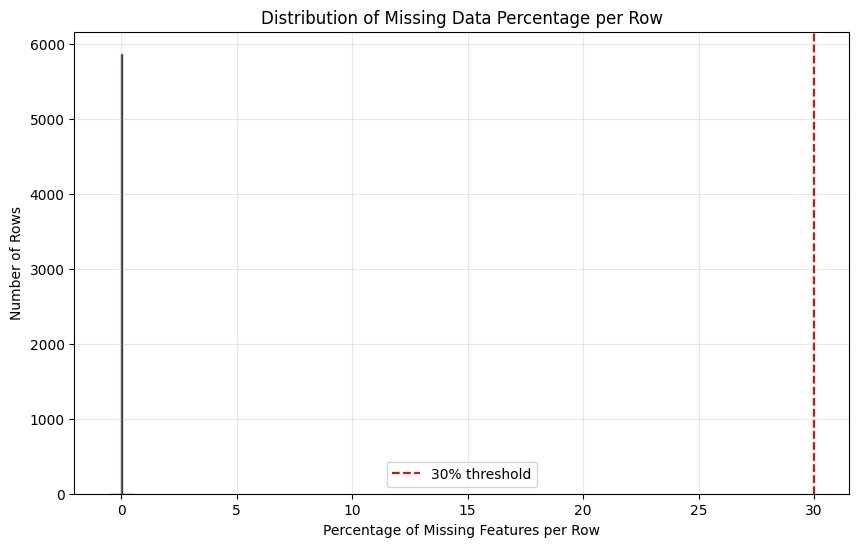

Rows with >30% missing features: 0
✅ No rows exceed 30% missing threshold

B.3 MISSINGNESS PATTERN ANALYSIS
Missingness pattern by subject:
Average missingness per subject: 0.00%
Subject missingness range: 0.00% - 0.00%

Missingness pattern by test_time:
Test time missingness range: 0.00% - 0.00%

B.4 TIME-AWARE IMPUTATION STRATEGY
Missing pattern analysis for sample subjects:

B.5 IMPUTATION PIPELINE DESIGN

B.6 PRE-IMPUTATION DOCUMENTATION
📋 Current dataset status:
Original shape: (5875, 23)
Current shape: (5875, 22)
Columns dropped: {'Jitter(Abs)'}

Missing values by data type:
  float64: 0 missing values
  int64: 0 missing values

B.7 IMPUTATION PLAN SUMMARY

🎯 IMPUTATION STRATEGY (to be applied AFTER train/test split):

1. PRIMARY METHOD: Time-aware interpolation per subject
   - Sort measurements by test_time for each subject
   - Forward fill (carry last observation forward)
   - Backward fill (carry next observation backward)
   - Final fallback: median imputation

2. ALTERNATI

,Unnamed: 0,index,subject#,age,sex,test_time,total_UPDRS,Jitter(%),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,2937.000000,2937.000000,21.494128,64.804936,0.317787,92.863722,29.018942,0.006154,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,1696.110747,1696.110747,12.372279,8.821524,0.465656,53.445602,10.700283,0.005624,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,0.000000,0.000000,1.000000,36.000000,0.000000,-4.262500,7.000000,0.000830,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,1468.500000,1468.500000,10.000000,58.000000,0.000000,46.847500,21.371000,0.003580,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,2937.000000,2937.000000,22.000000,65.000000,0.000000,91.523000,27.576000,0.004900,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,4405.500000,4405.500000,33.000000,72.000000,1.000000,138.445000,36.399000,0.006800,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,5874.000000,5874.000000,42.000000,85.000000,1.000000,215.490000,54.992000,0.099990,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730



Target variable 'total_UPDRS':
  Missing values: 0
  Range: 7.00 - 54.99
  Mean: 29.02

💾 Cleaned dataset (pre-imputation) saved for later use.
   Shape: (5875, 22)

B.9 MISSINGNESS VISUALIZATION
✅ No missing values to plot by column.


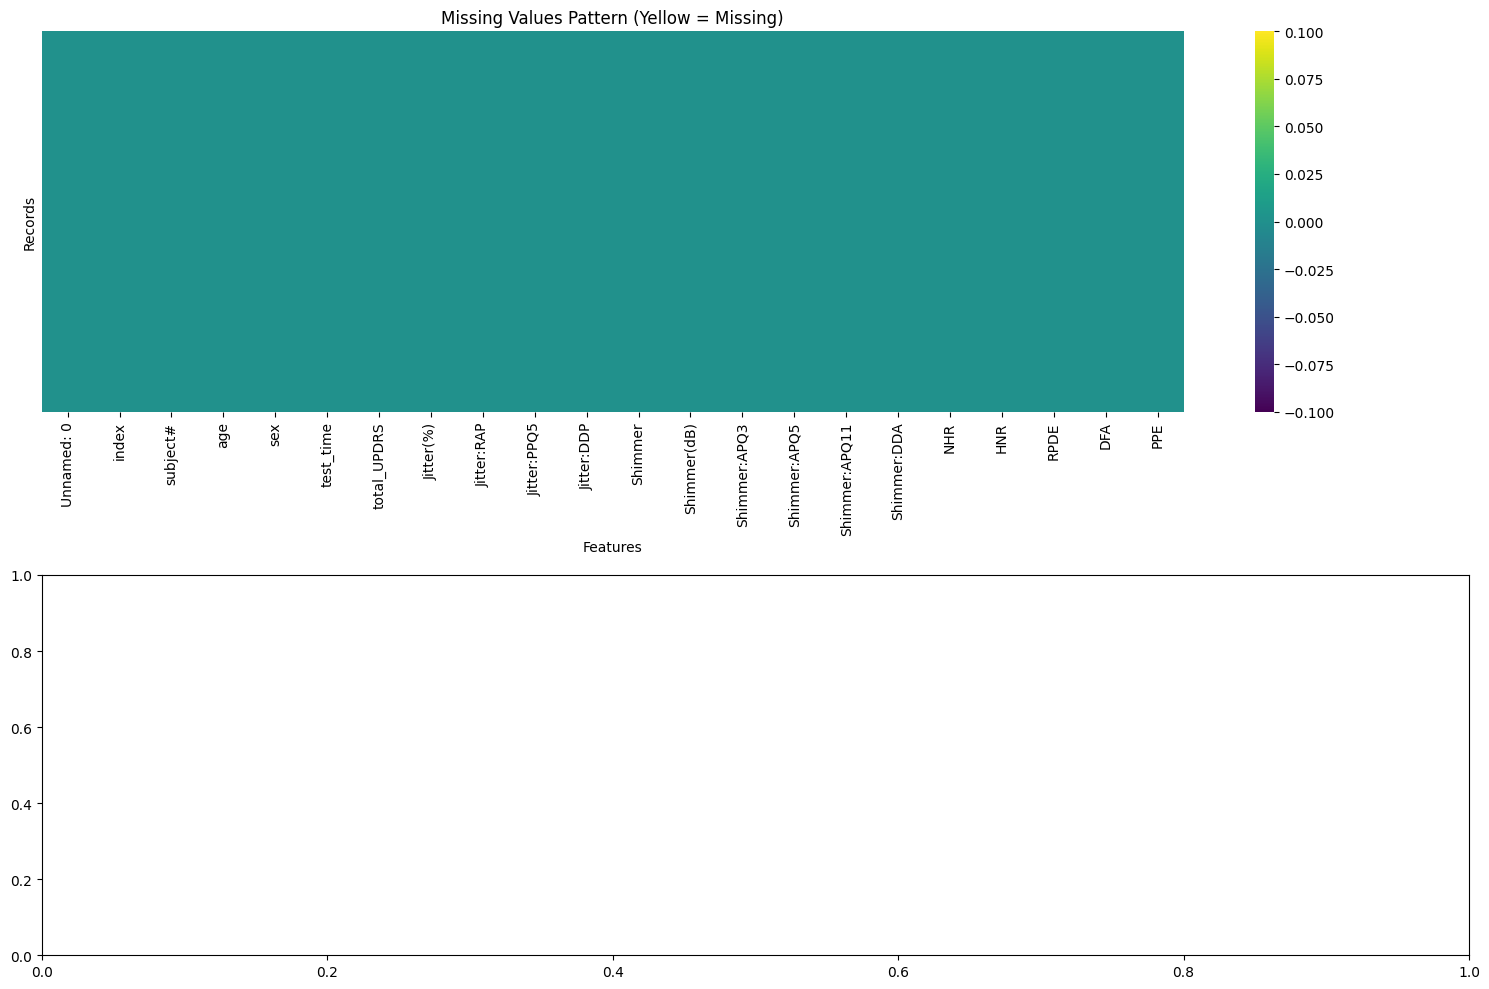

✅ Data Cleaning & Missing Value Strategy completed!
   Next step: Feature Engineering (Part C)


In [46]:
# =============================================================================
# B. DATA CLEANING & MISSING VALUE STRATEGY
# =============================================================================

print("=" * 80)
print("B. DATA CLEANING & MISSING VALUE STRATEGY")
print("=" * 80)

# Create a copy of the original dataframe for cleaning
df_clean = df.copy()

print("📊 Initial missing values summary:")
missing_summary = df_clean.isnull().sum()
missing_percent = (missing_summary / len(df_clean)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_summary,
    'Missing_Percent': missing_percent
}).sort_values('Missing_Percent', ascending=False)

# Display columns with missing values only
missing_df = missing_df[missing_df['Missing_Count'] > 0]
print(f"Columns with missing values: {len(missing_df)}")
display(missing_df)

# =============================================================================
# B.1 Column Threshold Analysis (>40% missing)
# =============================================================================
print("\n" + "="*50)
print("B.1 COLUMN THRESHOLD ANALYSIS (>40% missing)")
print("="*50)

high_missing_cols = missing_df[missing_df['Missing_Percent'] > 40].index.tolist()
print(f"Columns with >40% missing values: {high_missing_cols}")

if high_missing_cols:
    print("❌ These columns will be DROPPED due to high missingness")
    df_clean = df_clean.drop(columns=high_missing_cols)
    print(f"Remaining columns: {len(df_clean.columns)}")
else:
    print("✅ No columns exceed 40% missing threshold")

# =============================================================================
# B.2 Row Threshold Analysis (>30% missing features per row)
# =============================================================================
print("\n" + "="*50)
print("B.2 ROW THRESHOLD ANALYSIS (>30% missing features per row)")
print("="*50)

# Calculate missing percentage per row
row_missing_pct = (df_clean.isnull().sum(axis=1) / len(df_clean.columns)) * 100

plt.figure(figsize=(10, 6))
plt.hist(row_missing_pct, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=30, color='red', linestyle='--', label='30% threshold')
plt.xlabel('Percentage of Missing Features per Row')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Data Percentage per Row')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

high_missing_rows = row_missing_pct[row_missing_pct > 30]
print(f"Rows with >30% missing features: {len(high_missing_rows)}")

if len(high_missing_rows) > 0:
    print("📋 Affected rows (first 10):")
    for idx, pct in high_missing_rows.head(10).items():
        print(f"  Row {idx}: {pct:.1f}% missing")

    # Decision: Keep rows for time-series context but document
    print("⚠️  CAUTION: These rows contain time-series data. Will KEEP but handle with care during imputation.")
else:
    print("✅ No rows exceed 30% missing threshold")

# =============================================================================
# B.3 Analyze Missingness Patterns
# =============================================================================
print("\n" + "="*50)
print("B.3 MISSINGNESS PATTERN ANALYSIS")
print("="*50)

# Check if missingness is random or follows patterns
print("Missingness pattern by subject:")
subject_missing = df_clean.groupby('subject#').apply(
    lambda x: x.isnull().sum().sum() / (x.shape[0] * x.shape[1]) * 100
)
print(f"Average missingness per subject: {subject_missing.mean():.2f}%")
print(f"Subject missingness range: {subject_missing.min():.2f}% - {subject_missing.max():.2f}%")

# Check temporal patterns
print("\nMissingness pattern by test_time:")
time_missing = df_clean.groupby('test_time').apply(
    lambda x: x.isnull().sum().sum() / (x.shape[0] * x.shape[1]) * 100
)
print(f"Test time missingness range: {time_missing.min():.2f}% - {time_missing.max():.2f}%")

# =============================================================================
# B.4 Time-Aware Imputation Strategy
# =============================================================================
print("\n" + "="*50)
print("B.4 TIME-AWARE IMPUTATION STRATEGY")
print("="*50)

def analyze_missing_patterns_per_subject(df, subject_id):
    """Analyze missing patterns for a specific subject"""
    subject_data = df[df['subject#'] == subject_id].sort_values('test_time')
    missing_pattern = subject_data.isnull().sum()
    return missing_pattern[missing_pattern > 0]

# Test pattern analysis on a few subjects
sample_subjects = df_clean['subject#'].unique()[:3]
print("Missing pattern analysis for sample subjects:")
for subject in sample_subjects:
    pattern = analyze_missing_patterns_per_subject(df_clean, subject)
    if len(pattern) > 0:
        print(f"Subject {subject}: {pattern.to_dict()}")

# =============================================================================
# B.5 Implement Imputation Pipeline (Template for later use)
# =============================================================================
print("\n" + "="*50)
print("B.5 IMPUTATION PIPELINE DESIGN")
print("="*50)

class ParkinsonDataImputer:
    """Custom imputer for Parkinson's dataset with time-series awareness"""

    def __init__(self):
        self.column_medians_ = None
        self.is_fitted_ = False

    def fit(self, df):
        """Calculate medians for each column (to be used on training set only)"""
        self.column_medians_ = df.select_dtypes(include=[np.number]).median()
        self.is_fitted_ = True
        return self

    def transform(self, df, method='time_aware'):
        """Apply imputation based on specified method"""
        if not self.is_fitted_:
            raise ValueError("Imputer must be fitted before transformation")

        df_transformed = df.copy()

        if method == 'time_aware':
            df_transformed = self._time_aware_imputation(df_transformed)
        elif method == 'median':
            df_transformed = self._median_imputation(df_transformed)
        elif method == 'knn':
            df_transformed = self._knn_imputation(df_transformed)

        return df_transformed

    def _time_aware_imputation(self, df):
        """Time-aware interpolation per subject"""
        df_imputed = df.copy()

        # Group by subject and sort by test_time
        for subject in df['subject#'].unique():
            subject_mask = df['subject#'] == subject
            subject_data = df[subject_mask].sort_values('test_time')

            # For each numeric column, perform time-aware imputation
            numeric_cols = subject_data.select_dtypes(include=[np.number]).columns

            for col in numeric_cols:
                if subject_data[col].isnull().any():
                    # Try forward fill (carry last observation forward)
                    subject_data[col] = subject_data[col].fillna(method='ffill')
                    # Then backward fill
                    subject_data[col] = subject_data[col].fillna(method='bfill')
                    # Finally, use median if still missing
                    subject_data[col] = subject_data[col].fillna(self.column_medians_[col])

            # Update the main dataframe
            df_imputed.loc[subject_mask, numeric_cols] = subject_data[numeric_cols].values

        return df_imputed

    def _median_imputation(self, df):
        """Simple median imputation"""
        df_imputed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        for col in numeric_cols:
            df_imputed[col] = df_imputed[col].fillna(self.column_medians_[col])

        return df_imputed

    def _knn_imputation(self, df, k=5):
        """KNN imputation (simplified version)"""
        from sklearn.impute import KNNImputer

        df_imputed = df.copy()
        numeric_cols = df.select_dtypes(include=[np.number]).columns

        # Use KNN imputer
        imputer = KNNImputer(n_neighbors=k)
        df_numeric_imputed = imputer.fit_transform(df_imputed[numeric_cols])
        df_imputed[numeric_cols] = df_numeric_imputed

        return df_imputed

# =============================================================================
# B.6 Document Current State Before Imputation
# =============================================================================
print("\n" + "="*50)
print("B.6 PRE-IMPUTATION DOCUMENTATION")
print("="*50)

print("📋 Current dataset status:")
print(f"Original shape: {df.shape}")
print(f"Current shape: {df_clean.shape}")
print(f"Columns dropped: {set(df.columns) - set(df_clean.columns)}")

# Document missing values by type
print("\nMissing values by data type:")
for dtype in ['float64', 'int64', 'object']:
    cols = df_clean.select_dtypes(include=[dtype]).columns
    if len(cols) > 0:
        missing = df_clean[cols].isnull().sum().sum()
        print(f"  {dtype}: {missing} missing values")

# =============================================================================
# B.7 Create Imputation Plan Summary
# =============================================================================
print("\n" + "="*50)
print("B.7 IMPUTATION PLAN SUMMARY")
print("="*50)

imputation_plan = """
🎯 IMPUTATION STRATEGY (to be applied AFTER train/test split):

1. PRIMARY METHOD: Time-aware interpolation per subject
   - Sort measurements by test_time for each subject
   - Forward fill (carry last observation forward)
   - Backward fill (carry next observation backward)
   - Final fallback: median imputation

2. ALTERNATIVE METHODS (for comparison):
   - Median imputation (global): Simple and robust
   - KNN imputation (k=5): Uses feature similarity

3. CRITICAL CONSTRAINT:
   - Fit imputers ONLY on training data
   - Apply fitted imputers to validation/test data
   - Preserve temporal order within subjects

4. COLUMNS TO HANDLE SPECIALLY:
   - 'subject#', 'test_time': No missing values expected
   - 'sex': Binary, check for consistency
   - 'total_UPDRS': Target variable, handle with care
"""

print(imputation_plan)

# =============================================================================
# B.8 Final Pre-Imputation Check
# =============================================================================
print("\n" + "="*50)
print("B.8 FINAL PRE-IMPUTATION CHECK")
print("="*50)

# Check data types and ranges
print("Data types summary:")
print(df_clean.dtypes.value_counts())

print("\nNumeric ranges (post-cleaning, pre-imputation):")
numeric_summary = df_clean.select_dtypes(include=[np.number]).describe()
display(numeric_summary)

# Verify target variable integrity
print(f"\nTarget variable 'total_UPDRS':")
print(f"  Missing values: {df_clean['total_UPDRS'].isnull().sum()}")
print(f"  Range: {df_clean['total_UPDRS'].min():.2f} - {df_clean['total_UPDRS'].max():.2f}")
print(f"  Mean: {df_clean['total_UPDRS'].mean():.2f}")

# Save the cleaned (but not yet imputed) dataframe
df_cleaned_pre_imputation = df_clean.copy()
print(f"\n💾 Cleaned dataset (pre-imputation) saved for later use.")
print(f"   Shape: {df_cleaned_pre_imputation.shape}")

# =============================================================================
# B.9 Visualize Missingness Pattern
# =============================================================================
print("\n" + "="*50)
print("B.9 MISSINGNESS VISUALIZATION")
print("="*50)

# Create missingness matrix plot
plt.figure(figsize=(15, 10))

# Plot 1: Missingness heatmap
plt.subplot(2, 1, 1)
missing_matrix = df_clean.isnull()
sns.heatmap(missing_matrix, cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Pattern (Yellow = Missing)')
plt.xlabel('Features')
plt.ylabel('Records')

# Plot 2: Missingness by column
plt.subplot(2, 1, 2)
missing_by_col = df_clean.isnull().sum()
# Check if there are any missing values before plotting
if missing_by_col[missing_by_col > 0].shape[0] > 0:
    missing_by_col[missing_by_col > 0].plot(kind='bar', color='coral')
    plt.title('Missing Values Count by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Count')
    plt.xticks(rotation=45)
else:
    print("✅ No missing values to plot by column.")


plt.tight_layout()
plt.show()

print("✅ Data Cleaning & Missing Value Strategy completed!")
print("   Next step: Feature Engineering (Part C)")